<center><h1>Parte 1</h1></center>
<center><h1>Entender os Dados</h1></center>

<h2> Import das bibliotecas</h2>

In [1]:
import cv2
import os

from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

DATAPATH = "data/leaf.csv"
SEED = 42

XLABELS = [str(x) for x in range(1,15+1)] +[str(x) for x in range(22, 36+1)]
FEATURELABELS = ["Eccentricity", "Aspect Ratio", "Elongation", "Solidity", 
                 "Stoch. Convexity", "Isoperimetric Fac.", "Max. Identation Depth", "Lobedness", 
                "Avg. Intensity", "Avg. Contrast", "Smoothness", "Third Moment", "Uniformity", "Entropy"]

<h2>Leitura</h2>

In [2]:
leafdata = np.genfromtxt(DATAPATH, delimiter = ",")

X = leafdata[:, 2:]
Y = leafdata[:, 0]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42, shuffle=True)

models = []

randomf = RandomForestClassifier(n_estimators=10, criterion="gini", bootstrap = False)
models.append(("RF", randomf))

<h2>Entendimento</h2>

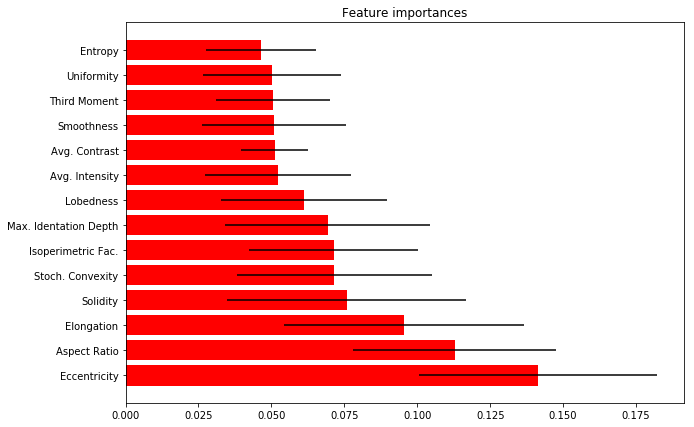

In [4]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
randomf.fit(X, Y)
importances = randomf.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

maior = max(importances)

# Print the feature ranking
#print("Feature ranking:")

#for f in range(X.shape[1]):
#    print("%d. %s (%f)" % (f + 1, FEATURELABELS[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize = (10,7))
plt.title("Feature importances")
plt.barh(range(X.shape[1]), (importances[indices]),
       color="r", xerr=std[indices] , align="center")
plt.yticks(range(X.shape[1]), FEATURELABELS)
plt.show()

<center><h1>Parte 2</h1></center>
<center><h1>Treinamento dos Modelo</h1></center>

<p>Treinamento do modelo</p>

In [ ]:
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=SEED)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring="accuracy")
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

<p>Árvore 1</p>

In [ ]:
randomf.fit(X_train, Y_train)
predictions = randomf.predict(X_test)

print(accuracy_score(Y_test, predictions))

conf = confusion_matrix(Y_test, predictions)
conf = conf.astype('float')

#for i in range(0, len(conf)):
#    conf[i] = (conf[i] / conf[i].sum())

sn.set(font_scale=2)
plt.figure(figsize = (15,13))
sn.heatmap(conf, annot=True,annot_kws={"size": 10}, xticklabels=XLABELS, yticklabels=XLABELS)